In [1]:
# Attempting to read the uploaded file again
import pandas as pd

# Load the dataset from the uploaded file
file_path = '/content/Dataset_Merchandising_esports (1).xlsx'
data = pd.read_excel(file_path)

# Display the first few rows of the dataset
data.head()


Date        Game  Earnings  Players  Tournaments  Merchandise Profit
0  1 01 1998  QuakeWorld   15000.0        8            1              3000.0
1  1 05 1998    Quake II   14600.0        4            1              2920.0
2  1 07 1998    Quake II   15000.0        5            1              3000.0
3  1 07 1998  QuakeWorld    6500.0        4            1              1300.0
4  1 11 1998    Quake II   36600.0       13            2              7320.0

In [5]:
!pip install shap eli5 lime scikit-learn pandas


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.2/216.2 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for eli5: filename=eli5-0.13.0-py2.py3-none-any.whl size=107720 sha256=cc5338543ecc5b34a391597b15150ed5947784763c7418ac11c77184d977c701
  Stored in directory: /root/.cache/pip/wheels/b8/58/ef/2cf4c306898c2338d51540e0922c8e0d6028e07007085c0004
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=86848bb248c86f4911203f69d26f680a3bb2a66209fe636688dd73ea18f4ec98
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built eli5 lime


In [15]:
data.columns

Index(['Date', 'Game', 'Earnings', 'Players', 'Tournaments',
       'Merchandise Profit'],
      dtype='object')

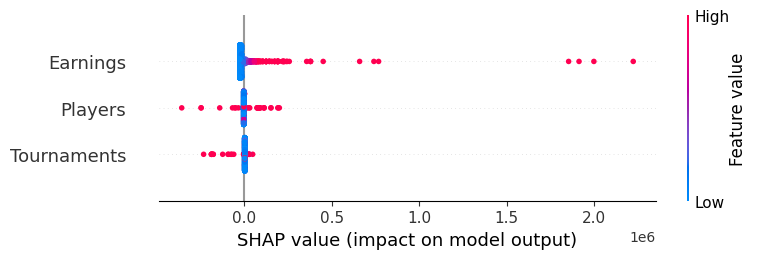

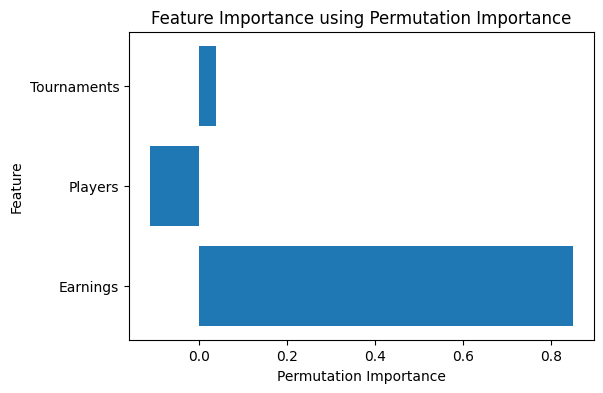

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(


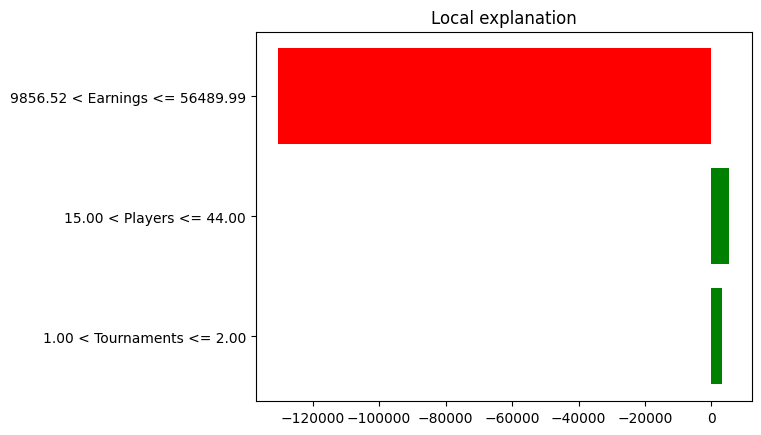

In [21]:
# SHAP analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# ELI5 analysis
perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
eli5.show_weights(perm, feature_names=X.columns.tolist())

# Extract weights for plotting
feature_weights = perm.feature_importances_
feature_names = X.columns

# Plot feature weights
plt.figure(figsize=(6, 4))
plt.barh(feature_names, feature_weights, align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Feature Importance using Permutation Importance')
plt.show()

# LIME analysis
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns.tolist(), class_names=['Merchandise Profit'], mode='regression')
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X_test.values[i], model.predict, num_features=len(X.columns))
exp.show_in_notebook(show_table=True)

# Display the LIME explanation
exp.as_pyplot_figure()
plt.show()


        Date        Game  Earnings  Players  Tournaments  Merchandise Profit
0  1 01 1998  QuakeWorld   15000.0        8            1              3000.0
1  1 05 1998    Quake II   14600.0        4            1              2920.0
2  1 07 1998    Quake II   15000.0        5            1              3000.0
3  1 07 1998  QuakeWorld    6500.0        4            1              1300.0
4  1 11 1998    Quake II   36600.0       13            2              7320.0
Mean Squared Error: 23224188002.643387


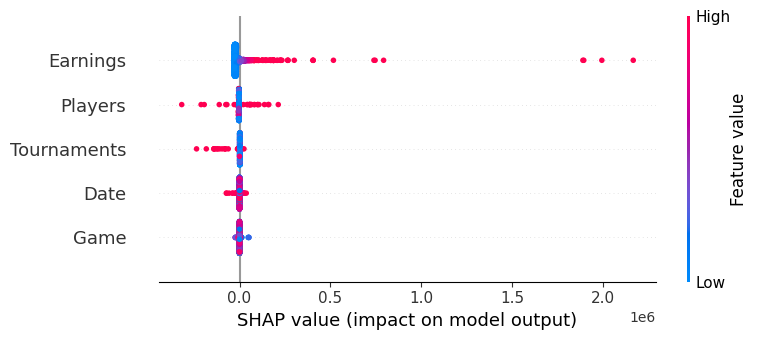

       feature    weight       std
0     Earnings  0.852899  0.029016
1  Tournaments  0.010811  0.001240
2         Game  0.010355  0.012630
3         Date -0.013388  0.013459
4      Players -0.104634  0.001740


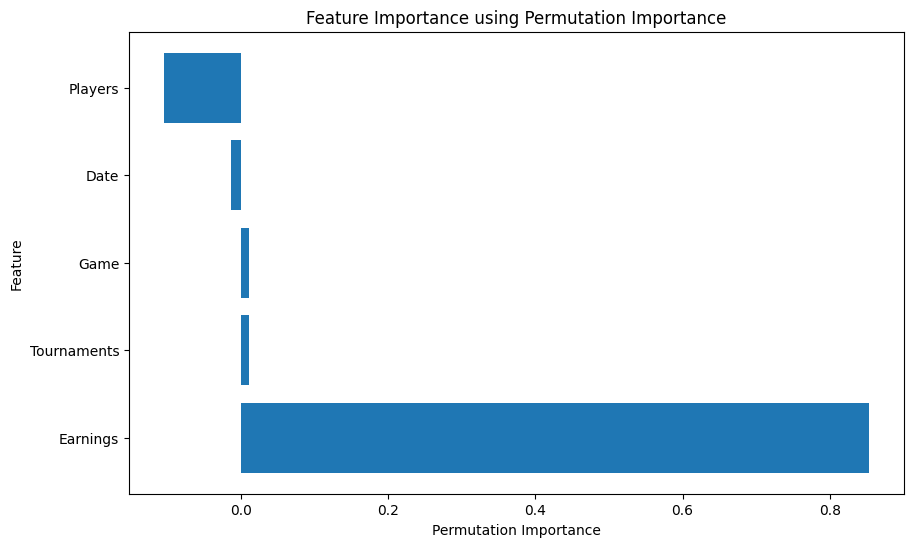

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(


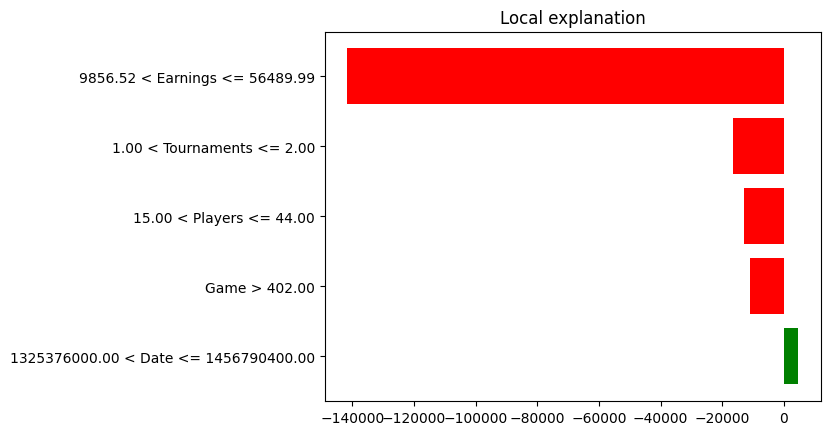

In [39]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import shap
import eli5
from eli5.sklearn import PermutationImportance
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = '/content/Dataset_Merchandising_esports (1).xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
print(df.head())

# Convert 'Date' to numerical format
df['Date'] = pd.to_datetime(df['Date'], format='%d %m %Y').astype(int) / 10**9

# Encode categorical variables using LabelEncoder
le = LabelEncoder()
df['Game'] = le.fit_transform(df['Game'])

# Feature selection
X = df.drop(columns=['Merchandise Profit'])
y = df['Merchandise Profit']

# Ensure all columns are numeric
X = X.apply(pd.to_numeric)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# SHAP analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# ELI5 analysis
perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
weights = eli5.explain_weights_df(perm, feature_names=X.columns.tolist())

# Ensure all features are displayed
print(weights)

# Plot feature weights
plt.figure(figsize=(10, 6))
plt.barh(weights['feature'], weights['weight'], align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Feature Importance using Permutation Importance')
plt.show()

# LIME analysis
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns.tolist(), class_names=['Merchandise Profit'], mode='regression')
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X_test.values[i], model.predict, num_features=len(X.columns))
exp.show_in_notebook(show_table=True)

# Display the LIME explanation
exp.as_pyplot_figure()
plt.show()


        Date        Game  Earnings  Players  Tournaments  Merchandise Profit
0  1 01 1998  QuakeWorld   15000.0        8            1              3000.0
1  1 05 1998    Quake II   14600.0        4            1              2920.0
2  1 07 1998    Quake II   15000.0        5            1              3000.0
3  1 07 1998  QuakeWorld    6500.0        4            1              1300.0
4  1 11 1998    Quake II   36600.0       13            2              7320.0
Mean Squared Error: 23224188002.643387


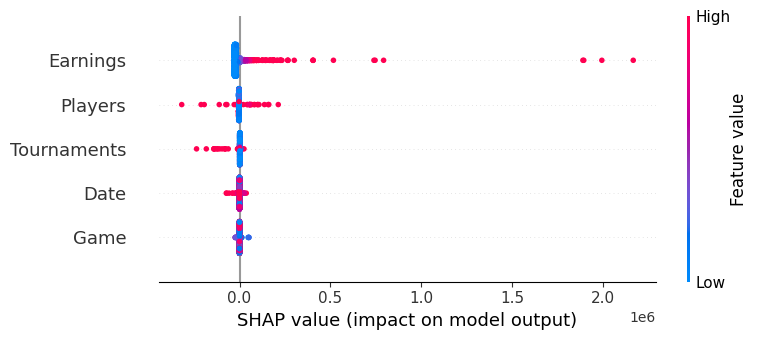

       feature    weight       std
0     Earnings  0.852899  0.029016
1  Tournaments  0.010811  0.001240
2         Game  0.010355  0.012630
3         Date -0.013388  0.013459
4      Players -0.104634  0.001740


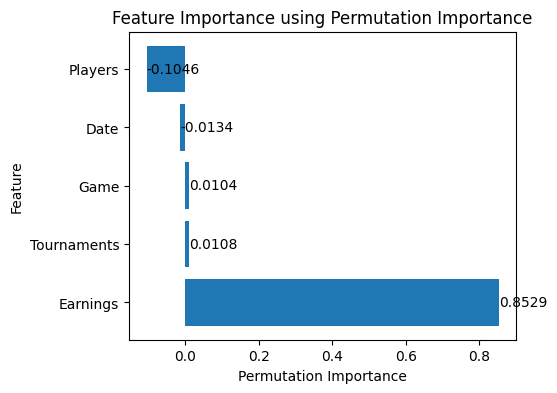

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but HistGradientBoostingRegressor was fitted with feature names
  warnings.warn(


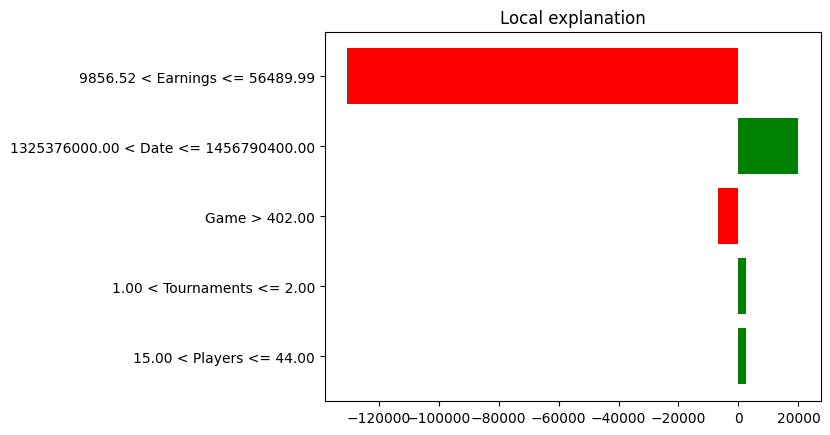

In [43]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import shap
import eli5
from eli5.sklearn import PermutationImportance
import lime
import lime.lime_tabular
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Load the dataset
file_path = '/content/Dataset_Merchandising_esports (1).xlsx'
df = pd.read_excel(file_path)

# Display the first few rows of the dataframe
print(df.head())

# Convert 'Date' to numerical format
df['Date'] = pd.to_datetime(df['Date'], format='%d %m %Y').astype(int) / 10**9

# Encode categorical variables using LabelEncoder
le = LabelEncoder()
df['Game'] = le.fit_transform(df['Game'])

# Feature selection
X = df.drop(columns=['Merchandise Profit'])
y = df['Merchandise Profit']

# Ensure all columns are numeric
X = X.apply(pd.to_numeric)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = HistGradientBoostingRegressor()
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# SHAP analysis
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# ELI5 analysis
perm = PermutationImportance(model, random_state=42).fit(X_test, y_test)
weights = eli5.explain_weights_df(perm, feature_names=X.columns.tolist())

# Ensure all features are displayed
print(weights)

# Plot feature weights with values
plt.figure(figsize=(5, 4))
bars = plt.barh(weights['feature'], weights['weight'], align='center')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Feature Importance using Permutation Importance')

# Annotate the bars with their values
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2, f'{bar.get_width():.4f}',
             va='center', ha='left')

plt.show()

# LIME analysis
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X.columns.tolist(), class_names=['Merchandise Profit'], mode='regression')
i = 0  # Index of the instance to explain
exp = explainer.explain_instance(X_test.values[i], model.predict, num_features=len(X.columns))
exp.show_in_notebook(show_table=True)

# Display the LIME explanation
exp.as_pyplot_figure()
plt.show()
